In [1]:
# Librairies import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import time
import warnings

from os import listdir
from matplotlib.image import imread

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
warnings.filterwarnings("ignore")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import test_functions as pf

# **Lecture des données**

In [4]:
data = pd.read_csv("flipkart_com-ecommerce_sample_1050.csv", sep=",")
print(data.shape)

(1050, 15)


**Extraction de la catégorie de niveau 0**

In [5]:
# On récupère la colomne "product_category_tree"
list_categories_0 = []
for txt in data["product_category_tree"] :
    
    list_categories_0.append(txt.split(">>")[0].split("\"")[1].strip()) # split du nom par >> et on récupère la première partie

# Création d'une nouvelle série catégorie    
data["category_0"] = pd.Series(list_categories_0)

In [6]:
data.head(2)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,category_0
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",Baby Care


**Création dataset réduit pour l'analyse d'image**

In [7]:
data_im = data[["uniq_id","product_name","image","category_0"]]
data_im.head(2)

,uniq_id,product_name,image,category_0
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care


In [8]:
path = "../P6/Images/"
listdir(path)[0:5] #affiche le nom des 5 premiers fichiers (images) du dossier

['009099b1f6e1e8f893ec29a7023153c4.jpg',
 '0096e89cc25a8b96fb9808716406fe94.jpg',
 '00cbbc837d340fa163d11e169fbdb952.jpg',
 '00d84a518e0550612fcfcba3b02b6255.jpg',
 '00e966a5049a262cfc72e6bbf68b80e7.jpg']

In [9]:
list_photos = [file for file in listdir(path)] #compte le nombre d'images dans le dossier
print("nombre d'images : ", len(list_photos))

nombre d'images :  1050


In [10]:
data_im.groupby("category_0").count() #observation des labels

,uniq_id,product_name,image
category_0,,,
Baby Care,150,150,150
Beauty and Personal Care,150,150,150
Computers,150,150,150
Home Decor & Festive Needs,150,150,150
Home Furnishing,150,150,150
Kitchen & Dining,150,150,150
Watches,150,150,150


In [11]:
list_labels = data_im.category_0.unique().tolist()
list_labels

['Home Furnishing',
 'Baby Care',
 'Watches',
 'Home Decor & Festive Needs',
 'Kitchen & Dining',
 'Beauty and Personal Care',
 'Computers']

**Affichages de quelques images par label :**

Home Furnishing


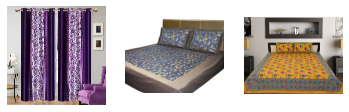

Baby Care


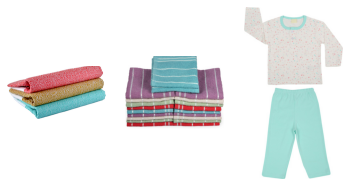

Watches


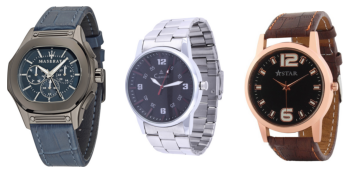

Home Decor & Festive Needs


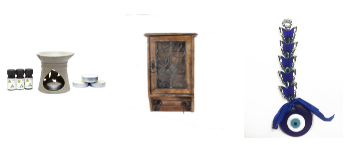

Kitchen & Dining


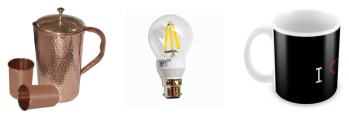

Beauty and Personal Care


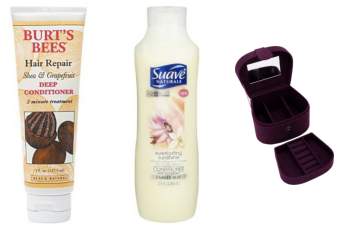

Computers


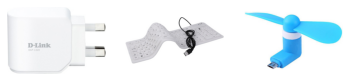

In [12]:
for categ in (list_labels) :
    print(categ)
    for i in range(3):
        name_image = data[data.category_0 == categ]["image"].iloc[i]
        plt.subplot(130 + 1 + i)
        filename = path + name_image
        img = imread(filename)
        plt.imshow(img)
        plt.axis('off')    
    plt.show() 

# Détermination et affichage des descripteurs SIFT

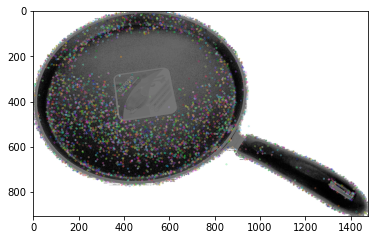

Descripteurs :  (4656, 128)

[[ 4.  2.  6. ...  5.  0.  0.]
 [96. 20.  0. ...  9.  2.  0.]
 [55. 16.  0. ...  0.  1.  0.]
 ...
 [12.  0.  0. ...  0.  0.  0.]
 [67. 19.  5. ...  0. 34. 13.]
 [ 0.  5. 27. ...  0.  0.  0.]]


In [13]:
import cv2

sift = cv2.xfeatures2d.SIFT_create()
image = cv2.imread(path+list_photos[1],0) # convert in gray
image = cv2.equalizeHist(image)   # equalize image histogram
kp, des = sift.detectAndCompute(image, None)
img=cv2.drawKeypoints(image,kp,image)
plt.imshow(img)
plt.show()
print("Descripteurs : ", des.shape)
print()
print(des)


# Pré-traitement des images via SIFT

## Créations des descripteurs de chaque image
* Pour chaque image passage en gris et equalisation
* création d'une liste de descripteurs par image ("sift_keypoints_by_img") qui sera utilisée pour réaliser les histogrammes par image
* création d'une liste de descripteurs pour l'ensemble des images ("sift_keypoints_all") qui sera utilisé pour créer les clusters de descripteurs

In [14]:
# identification of key points and associated descriptors
import time, cv2
sift_keypoints = []
temps1=time.time()
sift = cv2.xfeatures2d.SIFT_create(500)

for image_num in range(len(list_photos)) :
    if image_num%100 == 0 : print(image_num)
    image = cv2.imread(path+list_photos[image_num],0) # convert in gray
    # image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    res = cv2.equalizeHist(image)   # equalize image histogram
    kp, des = sift.detectAndCompute(res, None)
    sift_keypoints.append(des)

sift_keypoints_by_img = np.asarray(sift_keypoints)
sift_keypoints_all    = np.concatenate(sift_keypoints_by_img, axis=0)

print()
print("Nombre de descripteurs : ", sift_keypoints_all.shape)

duration1=time.time()-temps1
print("temps de traitement SIFT descriptor : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000

Nombre de descripteurs :  (517351, 128)
temps de traitement SIFT descriptor :           210.83 secondes


## Création des clusters de descripteurs
* Utilisation de MiniBatchKMeans pour obtenir des temps de traitement raisonnables

In [15]:
from sklearn import cluster, metrics

# Determination number of clusters
temps1=time.time()

k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(sift_keypoints_all)

duration1=time.time()-temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters estimés :  719
Création de 719 clusters de descripteurs ...
temps de traitement kmeans :            13.03 secondes


## Création des features des images
* Pour chaque image : 
   - prédiction des numéros de cluster de chaque descripteur
   - création d'un histogramme = comptage pour chaque numéro de cluster du nombre de descripteurs de l'image

Features d'une image = Histogramme d'une image = Comptage pour une image du nombre de descripteurs par cluster

In [16]:
# Creation of histograms (features)
temps1=time.time()

#bag of visual words
def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(sift_keypoints_by_img) :
    if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1=time.time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")


0
100
200
300
400
500
600
700
800
900
1000
temps de création histogrammes :            45.22 secondes


## Réductions de dimension

### Réduction de dimension PCA
* La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%)
* L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE

In [17]:
from sklearn import manifold, decomposition

print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 719)
Dimensions dataset après réduction PCA :  (1050, 498)


### Réduction de dimension T-SNE
* Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des images

In [18]:
from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data_im["category_0"]
print(df_tsne.shape)

(1050, 3)


## Analyse visuelle : affichage T-SNE selon catégories d'images
* aucune séparation

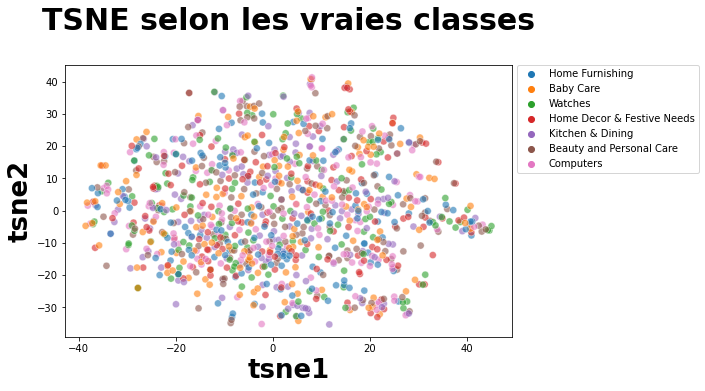

In [19]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(bbox_to_anchor=(1.0, 1.02), loc='upper left')

plt.show()

## Analyse mesures : similarité entre catégories et clusters

###  Création de clusters à partir du T-SNE

In [20]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1050, 4)


###  Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters

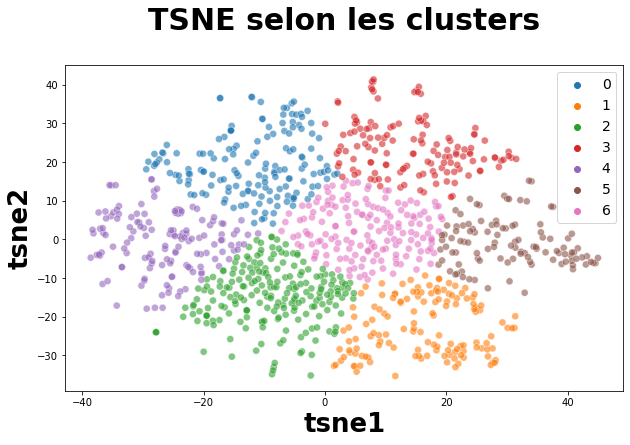

ARI :  -0.002128274091125394


In [21]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = data_im["category_0"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

* Le score ARI est faible

### Analyse par classes

In [22]:
df_tsne.groupby("cluster").count()["class"]

cluster
0    157
1    137
2    211
3    135
4    140
5    107
6    163
Name: class, dtype: int64

In [23]:
df_tsne.head()

,tsne1,tsne2,class,cluster
0,21.035894,11.207587,Home Furnishing,3
1,-17.397392,-20.852905,Baby Care,2
2,27.400688,-25.032431,Baby Care,1
3,-6.534204,-9.813621,Home Furnishing,2
4,-2.101417,27.380484,Home Furnishing,0


In [24]:
labels

0       Home Furnishing
1             Baby Care
2             Baby Care
3       Home Furnishing
4       Home Furnishing
             ...       
1045          Baby Care
1046          Baby Care
1047          Baby Care
1048          Baby Care
1049          Baby Care
Name: category_0, Length: 1050, dtype: object

In [25]:
cls.labels_

array([3, 2, 1, ..., 5, 6, 2])

In [26]:
conf_mat = metrics.confusion_matrix(labels, cls.labels_.astype(str))
print(conf_mat)

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [17 16 36 25 22 12 22  0  0  0  0  0  0  0]
 [28 19 26 17 15 21 24  0  0  0  0  0  0  0]
 [21 23 27 21 21 13 24  0  0  0  0  0  0  0]
 [22 19 30 21 20 14 24  0  0  0  0  0  0  0]
 [21 20 37 14 17 17 24  0  0  0  0  0  0  0]
 [27 23 26 16 22 12 24  0  0  0  0  0  0  0]
 [21 17 29 21 23 18 21  0  0  0  0  0  0  0]]


# CNN

In [27]:
data_im['image_loc'] = [path + row for row in data_im['image']]
data_im.head()

,uniq_id,product_name,image,category_0,image_loc
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,../P6/Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg
1,7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,../P6/Images/7b72c92c2f6c40268628ec5f14c6d590.jpg
2,64d5d4a258243731dc7bbb1eef49ad74,Eurospa Cotton Terry Face Towel Set,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,../P6/Images/64d5d4a258243731dc7bbb1eef49ad74.jpg
3,d4684dcdc759dd9cdf41504698d737d8,SANTOSH ROYAL FASHION Cotton Printed King size...,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing,../P6/Images/d4684dcdc759dd9cdf41504698d737d8.jpg
4,6325b6870c54cd47be6ebfbffa620ec7,Jaipur Print Cotton Floral King sized Double B...,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing,../P6/Images/6325b6870c54cd47be6ebfbffa620ec7.jpg


In [28]:
# Utilisation de VGG16 pré-entraîné sur ImageNet avec les images d'origine
# VGG16 imports
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
import keras
import tensorflow as tf

# Liste
vgg16_all_features = []

# Instanciation du modèle
model_vgg16 = VGG16(weights='imagenet', include_top=True, classifier_activation='softmax')
# Résumé de l'architecture du modèle
model_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [29]:
#fonction d'extraction de feature vgg16
def vgg16_extract_feature(im):
    
    #---
    # input : (image location + name image), exemple : "../P6/Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg"
    # output : (features image)
    #---
    
    # charge l'image et la reshape en taille requise pour le réseau de neurone (224, 224)
    img = keras.utils.load_img(im, target_size=(224, 224))
    
    # convertit les pixels en un tableau NumPy 
    img = keras.utils.img_to_array(img)
    
    # reshape
    img = np.expand_dims(img, axis=0)
    
    # prépare de nouvelles entrées pour le réseau.
    img = preprocess_input(img) 

    # obtient une prédiction de la probabilité d'appartenance
    # de l'image à chacun des 1000 types d'objets connus.
    vgg16_feature = model_vgg16.predict(img).flatten()
      
    return vgg16_feature

In [30]:
#extraction de features pour chaque image
data_im['vgg16_bovw'] = data_im['image_loc'].apply(lambda x : vgg16_extract_feature(x))

1/1 [==============================] - 0s 125ms/step


In [31]:
# Dataframe de travail
df_vgg16_bovw = data_im[['image', 'image_loc', 'category_0', 'vgg16_bovw']]
df_vgg16_bovw

,image,image_loc,category_0,vgg16_bovw
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,../P6/Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,"[2.150993e-09, 4.803102e-07, 9.212817e-09, 2.2..."
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,../P6/Images/7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,"[4.978918e-16, 5.1181123e-15, 1.0723886e-16, 3..."
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,../P6/Images/64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,"[2.1111238e-07, 1.721075e-07, 1.8250358e-08, 9..."
3,d4684dcdc759dd9cdf41504698d737d8.jpg,../P6/Images/d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing,"[7.817683e-09, 1.0448534e-08, 6.5374652e-09, 2..."
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,../P6/Images/6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing,"[2.7402966e-10, 4.0253333e-08, 7.036822e-10, 3..."
...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc.jpg,../P6/Images/958f54f4c46b53c8a0a9b8167d9140bc.jpg,Baby Care,"[1.2465563e-08, 5.4575444e-06, 4.962378e-08, 4..."
1046,fd6cbcc22efb6b761bd564c28928483c.jpg,../P6/Images/fd6cbcc22efb6b761bd564c28928483c.jpg,Baby Care,"[1.6079287e-07, 2.3227802e-05, 5.0323497e-06, ..."
1047,5912e037d12774bb73a2048f35a00009.jpg,../P6/Images/5912e037d12774bb73a2048f35a00009.jpg,Baby Care,"[9.277104e-09, 4.0813832e-09, 4.304229e-08, 3...."
1048,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,../P6/Images/c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,Baby Care,"[2.6203336e-06, 4.508078e-06, 1.1077476e-05, 2..."


In [32]:
# création dataframe de vecteurs de BOVW VGG16
df_vgg16_vectors = pd.DataFrame.from_records(df_vgg16_bovw["vgg16_bovw"])

In [33]:
print("Dimensions dataset avant réduction PCA : ", df_vgg16_vectors.shape)
pca = decomposition.PCA(n_components=0.95)
pca_results_vgg16 = pca.fit_transform(df_vgg16_vectors)
print("Dimensions dataset après réduction PCA : ", pca_results_vgg16.shape)

Dimensions dataset avant réduction PCA :  (1050, 1000)
Dimensions dataset après réduction PCA :  (1050, 133)


In [34]:
l_cat = list(set(data_im['category_0']))
l_cat

['Computers',
 'Baby Care',
 'Home Decor & Festive Needs',
 'Kitchen & Dining',
 'Beauty and Personal Care',
 'Watches',
 'Home Furnishing']

In [35]:
df_vgg16_vectors

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999
0,2.150993e-09,4.803102e-07,9.212817e-09,2.261125e-08,6.254785e-09,6.128062e-08,1.537718e-08,4.596250e-08,3.064167e-08,5.374191e-08,1.456154e-07,2.573859e-07,6.601451e-07,1.596073e-07,9.337770e-07,2.128898e-07,8.976598e-08,1.102401e-06,3.003750e-07,1.686574e-06,3.390779e-08,4.982879e-09,2.500800e-08,5.673479e-08,1.314483e-07,1.793408e-08,2.406514e-07,4.063793e-08,8.633405e-09,2.229961e-07,8.454580e-08,2.364739e-07,1.354501e-07,3.030173e-08,9.999155e-08,3.535400e-09,5.918425e-08,1.205763e-08,1.972633e-07,7.399821e-07,7.823624e-08,2.682036e-08,1.050618e-07,2.907306e-07,2.957186e-08,7.784347e-07,2.202971e-07,2.153180e-06,2.969797e-07,5.464378e-07,...,6.070515e-07,1.213359e-07,1.053309e-07,2.736884e-07,1.197502e-06,2.930488e-07,2.138082e-07,1.552470e-07,2.696230e-06,5.140203e-08,6.432126e-08,1.517876e-07,7.199999e-08,8.444416e-07,2.737376e-08,6.646818e-08,4.410124e-06,4.976020e-08,6.884107e-06,2.769624e-07,1.175037e-06,7.532256e-06,1.608551e-07,6.283756e-06,3.895021e-08,2.593696e-06,4.948702e-07,9.825679e-07,1.826455e-06,6.227943e-08,1.684890e-07,1.095373e-08,1.036387e-04,3.155157e-08,1.560758e-07,5.212625e-07,7.859865e-08,1.401541e-06,8.268234e-08,7.922810e-08,4.856782e-07,2.766868e-07,7.384251e-08,6.619992e-09,4.388904e-09,4.479569e-08,1.826836e-07,9.259077e-09,6.433773e-07,4.032610e-06
1,4.978918e-16,5.118112e-15,1.072389e-16,3.978408e-16,6.948786e-17,3.696939e-14,4.953301e-18,5.977706e-14,1.581487e-13,5.929648e-14,5.304240e-15,3.733437e-15,2.109649e-14,1.139816e-15,8.613283e-14,6.892324e-15,2.589571e-15,7.856137e-14,2.579757e-14,1.078569e-13,1.638251e-15,2.944178e-16,3.012112e-16,2.165790e-15,6.641949e-16,1.126515e-15,1.502651e-14,1.097293e-14,4.218995e-17,2.790186e-14,1.598700e-14,5.286590e-13,5.041268e-13,6.258485e-16,8.726714e-16,1.478794e-16,3.443291e-14,4.720531e-16,4.753587e-14,2.169917e-15,1.623009e-14,3.984501e-15,2.681633e-14,1.330117e-15,8.531815e-16,1.723867e-13,2.750803e-14,2.536938e-15,2.067896e-16,4.445603e-17,...,3.637198e-12,1.483447e-12,5.769233e-14,3.758118e-13,1.852489e-10,3.934630e-13,8.513503e-14,2.033786e-13,1.753566e-11,1.151748e-15,5.101766e-12,4.356408e-10,3.219149e-11,2.167648e-13,1.000711e-12,8.052372e-10,3.136023e-12,5.582911e-13,2.787383e-10,1.167541e-10,4.507424e-15,7.523820e-15,4.991472e-15,3.894531e-15,5.101853e-16,6.527016e-15,1.157665e-14,4.953039e-13,2.758968e-14,4.015751e-15,8.813761e-17,6.368452e-15,3.522876e-14,4.882000e-17,4.069017e-13,1.756268e-14,1.788898e-16,3.726130e-12,2.975405e-14,6.225034e-15,1.712640e-12,4.993033e-15,2.467953e-15,6.425869e-16,1.030765e-13,9.145806e-14,5.159441e-13,4.542787e-14,3.406205e-12,2.076964e-08
2,2.111124e-07,1.721075e-07,1.825036e-08,9.966799e-09,5.116243e-08,2.648134e-07,5.047916e-08,3.386213e-08,4.994933e-08,4.750996e-08,2.088988e-08,5.849085e-09,1.786224e-08,1.516301e-08,6.804474e-08,2.066995e-08,5.180530e-09,1.605297e-07,2.712499e-08,5.528919e-08,1.184391e-08,1.464785e-07,1.538884e-08,5.594134e-08,1.028589e-07,4.960479e-08,6.535480e-08,3.508245e-07,5.077784e-08,4.512339e-08,1.172301e-08,7.408636e-08,2.159274e-07,7.601060e-08,2.748838e-07,7.000735e-08,2.127533e-07,6.003072e-08,6.658939e-07,1.214616e-08,7.824586e-08,4.784780e-08,7.458586e-08,5.507668e-08,4.215118e-08,7.463995e-08,7.412056e-08,4.947271e-07,4.281350e-08,5.019696e-09,...,1.097592e-07,1.587874e-07,1.053567e-07,8.090422e-08,2.940670e-07,3.037065e-07,6.994642e-08,1.528587e-08,6.922587e-06,5.676564e-08,3.676078e-08,1.099156e-06,2.087175e-07,1.034717e-07,1.195493e-07,2.245925e-07,3.313323e-07,6.769000e-08,1.051054e-06,1.404087e-07,1.740825e-07,2.554733e-07,3.456794e-07,7.632386e-07,1.395911e-07,1.189399e-07,1.060565e-07,1.040557e-06,2.862226e-07,2.308050e-

In [36]:
y_cat_num = [(l_cat.index(data_im.iloc[i]['category_0'])) for i in range(len(data_im))]
y_cat_num = pd.Series(y_cat_num) 
print(y_cat_num)

0       6
1       1
2       1
3       6
4       6
       ..
1045    1
1046    1
1047    1
1048    1
1049    1
Length: 1050, dtype: int64


In [37]:
ARI, X_tsne, labels = pf.ARI_fct(df_vgg16_vectors, l_cat, y_cat_num) 

ARI :  0.3876 time :  10.0


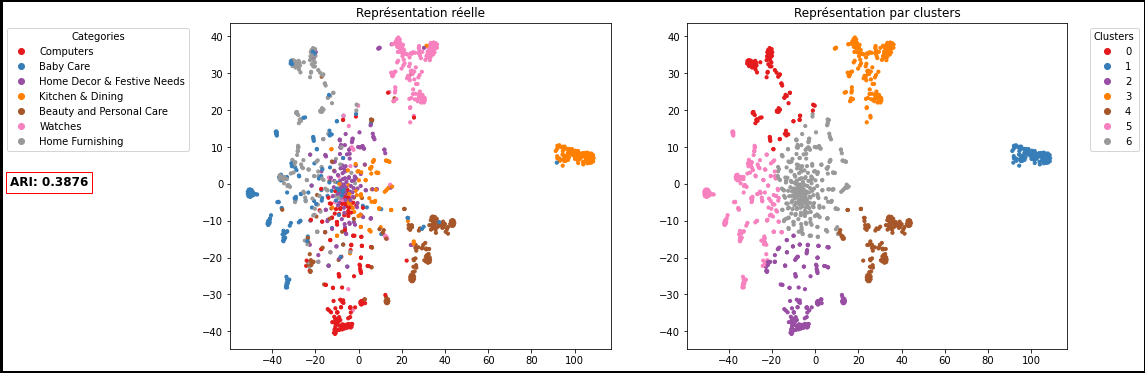

ARI :  0.3876


In [38]:
pf.TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI, l_cat)

---

In [39]:
conf_mat = metrics.confusion_matrix(y_cat_num, labels)
print(conf_mat)

[[  2   0  99   3   1   7  38]
 [ 21   1   4   0   5  97  22]
 [  4   0   8   6   2   8 122]
 [  0  75   3   1   7   0  64]
 [  1   0  25   2  99   9  14]
 [  3   0   2 130   5   0  10]
 [ 71   0   4   0   0  60  15]]


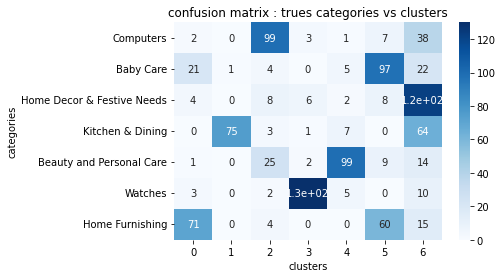

In [40]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in l_cat],
                  columns = [i for i in "0123456"])

plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")
plt.title("confusion matrix : trues categories vs clusters")
plt.xlabel("clusters")
plt.ylabel("categories")
plt.show()

In [41]:
print(metrics.classification_report(y_cat_num, labels))

              precision    recall  f1-score   support

           0       0.02      0.01      0.02       150
           1       0.01      0.01      0.01       150
           2       0.06      0.05      0.05       150
           3       0.01      0.01      0.01       150
           4       0.83      0.66      0.74       150
           5       0.00      0.00      0.00       150
           6       0.05      0.10      0.07       150

    accuracy                           0.12      1050
   macro avg       0.14      0.12      0.13      1050
weighted avg       0.14      0.12      0.13      1050



In [42]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

cls_labels_transform = conf_mat_transform(y_cat_num, labels)
conf_mat = metrics.confusion_matrix(y_cat_num, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(y_cat_num, cls_labels_transform))

Correspondance des clusters :  [6 3 0 5 4 1 2]
[[ 99   7  38   0   1   3   2]
 [  4  97  22   1   5   0  21]
 [  8   8 122   0   2   6   4]
 [  3   0  64  75   7   1   0]
 [ 25   9  14   0  99   2   1]
 [  2   0  10   0   5 130   3]
 [  4  60  15   0   0   0  71]]

              precision    recall  f1-score   support

           0       0.68      0.66      0.67       150
           1       0.54      0.65      0.59       150
           2       0.43      0.81      0.56       150
           3       0.99      0.50      0.66       150
           4       0.83      0.66      0.74       150
           5       0.92      0.87      0.89       150
           6       0.70      0.47      0.56       150

    accuracy                           0.66      1050
   macro avg       0.73      0.66      0.67      1050
weighted avg       0.73      0.66      0.67      1050



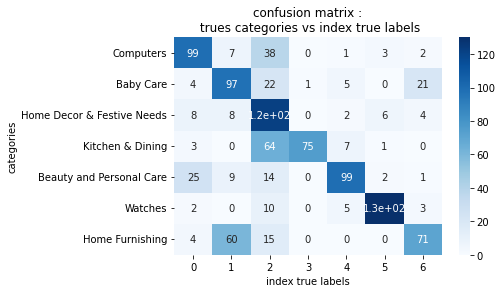

In [43]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in l_cat],
                  columns = [i for i in "0123456"])

plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")
plt.title("confusion matrix :\n trues categories vs index true labels")
plt.xlabel("index true labels")
plt.ylabel("categories")
plt.show()

---

# **Essai de combinaison des vecteurs**

In [44]:
df_vgg16_vectors

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999
0,2.150993e-09,4.803102e-07,9.212817e-09,2.261125e-08,6.254785e-09,6.128062e-08,1.537718e-08,4.596250e-08,3.064167e-08,5.374191e-08,1.456154e-07,2.573859e-07,6.601451e-07,1.596073e-07,9.337770e-07,2.128898e-07,8.976598e-08,1.102401e-06,3.003750e-07,1.686574e-06,3.390779e-08,4.982879e-09,2.500800e-08,5.673479e-08,1.314483e-07,1.793408e-08,2.406514e-07,4.063793e-08,8.633405e-09,2.229961e-07,8.454580e-08,2.364739e-07,1.354501e-07,3.030173e-08,9.999155e-08,3.535400e-09,5.918425e-08,1.205763e-08,1.972633e-07,7.399821e-07,7.823624e-08,2.682036e-08,1.050618e-07,2.907306e-07,2.957186e-08,7.784347e-07,2.202971e-07,2.153180e-06,2.969797e-07,5.464378e-07,...,6.070515e-07,1.213359e-07,1.053309e-07,2.736884e-07,1.197502e-06,2.930488e-07,2.138082e-07,1.552470e-07,2.696230e-06,5.140203e-08,6.432126e-08,1.517876e-07,7.199999e-08,8.444416e-07,2.737376e-08,6.646818e-08,4.410124e-06,4.976020e-08,6.884107e-06,2.769624e-07,1.175037e-06,7.532256e-06,1.608551e-07,6.283756e-06,3.895021e-08,2.593696e-06,4.948702e-07,9.825679e-07,1.826455e-06,6.227943e-08,1.684890e-07,1.095373e-08,1.036387e-04,3.155157e-08,1.560758e-07,5.212625e-07,7.859865e-08,1.401541e-06,8.268234e-08,7.922810e-08,4.856782e-07,2.766868e-07,7.384251e-08,6.619992e-09,4.388904e-09,4.479569e-08,1.826836e-07,9.259077e-09,6.433773e-07,4.032610e-06
1,4.978918e-16,5.118112e-15,1.072389e-16,3.978408e-16,6.948786e-17,3.696939e-14,4.953301e-18,5.977706e-14,1.581487e-13,5.929648e-14,5.304240e-15,3.733437e-15,2.109649e-14,1.139816e-15,8.613283e-14,6.892324e-15,2.589571e-15,7.856137e-14,2.579757e-14,1.078569e-13,1.638251e-15,2.944178e-16,3.012112e-16,2.165790e-15,6.641949e-16,1.126515e-15,1.502651e-14,1.097293e-14,4.218995e-17,2.790186e-14,1.598700e-14,5.286590e-13,5.041268e-13,6.258485e-16,8.726714e-16,1.478794e-16,3.443291e-14,4.720531e-16,4.753587e-14,2.169917e-15,1.623009e-14,3.984501e-15,2.681633e-14,1.330117e-15,8.531815e-16,1.723867e-13,2.750803e-14,2.536938e-15,2.067896e-16,4.445603e-17,...,3.637198e-12,1.483447e-12,5.769233e-14,3.758118e-13,1.852489e-10,3.934630e-13,8.513503e-14,2.033786e-13,1.753566e-11,1.151748e-15,5.101766e-12,4.356408e-10,3.219149e-11,2.167648e-13,1.000711e-12,8.052372e-10,3.136023e-12,5.582911e-13,2.787383e-10,1.167541e-10,4.507424e-15,7.523820e-15,4.991472e-15,3.894531e-15,5.101853e-16,6.527016e-15,1.157665e-14,4.953039e-13,2.758968e-14,4.015751e-15,8.813761e-17,6.368452e-15,3.522876e-14,4.882000e-17,4.069017e-13,1.756268e-14,1.788898e-16,3.726130e-12,2.975405e-14,6.225034e-15,1.712640e-12,4.993033e-15,2.467953e-15,6.425869e-16,1.030765e-13,9.145806e-14,5.159441e-13,4.542787e-14,3.406205e-12,2.076964e-08
2,2.111124e-07,1.721075e-07,1.825036e-08,9.966799e-09,5.116243e-08,2.648134e-07,5.047916e-08,3.386213e-08,4.994933e-08,4.750996e-08,2.088988e-08,5.849085e-09,1.786224e-08,1.516301e-08,6.804474e-08,2.066995e-08,5.180530e-09,1.605297e-07,2.712499e-08,5.528919e-08,1.184391e-08,1.464785e-07,1.538884e-08,5.594134e-08,1.028589e-07,4.960479e-08,6.535480e-08,3.508245e-07,5.077784e-08,4.512339e-08,1.172301e-08,7.408636e-08,2.159274e-07,7.601060e-08,2.748838e-07,7.000735e-08,2.127533e-07,6.003072e-08,6.658939e-07,1.214616e-08,7.824586e-08,4.784780e-08,7.458586e-08,5.507668e-08,4.215118e-08,7.463995e-08,7.412056e-08,4.947271e-07,4.281350e-08,5.019696e-09,...,1.097592e-07,1.587874e-07,1.053567e-07,8.090422e-08,2.940670e-07,3.037065e-07,6.994642e-08,1.528587e-08,6.922587e-06,5.676564e-08,3.676078e-08,1.099156e-06,2.087175e-07,1.034717e-07,1.195493e-07,2.245925e-07,3.313323e-07,6.769000e-08,1.051054e-06,1.404087e-07,1.740825e-07,2.554733e-07,3.456794e-07,7.632386e-07,1.395911e-07,1.189399e-07,1.060565e-07,1.040557e-06,2.862226e-07,2.308050e-

In [45]:
vgg16_vector = df_vgg16_vectors.to_numpy().reshape(-1,1)
vgg16_vector

array([[2.1509929e-09],
       [4.8031018e-07],
       [9.2128172e-09],
       ...,
       [7.5338187e-07],
       [1.4695426e-05],
       [9.7892282e-04]], dtype=float32)

In [46]:
vgg16_vector.shape

(1050000, 1)

Load le vecteur du tf-idf

In [47]:
tf_idf_vector = np.load('tf_idf_vector.npy') # load
tf_idf_vector.shape

(5590200, 1)

Combine les vecteurs des deux modèles

In [48]:
combinated_vector = np.concatenate([vgg16_vector,tf_idf_vector])
combinated_vector.shape

(6640200, 1)

In [50]:
combinated_matrix = np.reshape(combinated_vector, (1050, 6324))
combinated_matrix.shape

(1050, 6324)

In [51]:
ARI, X_tsne, labels = pf.ARI_fct(combinated_matrix, l_cat, y_cat_num) 

ARI :  -0.0003 time :  4.0


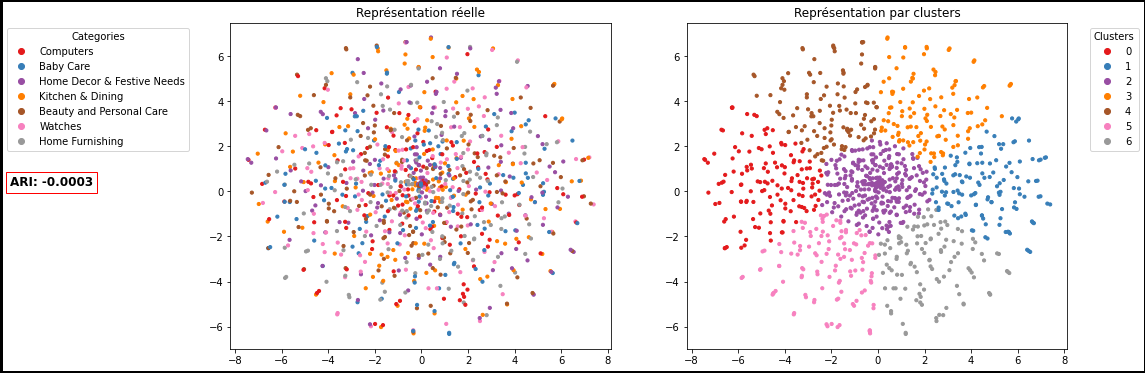

ARI :  -0.0003


In [52]:
pf.TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI, l_cat)